In [1]:
from collections import Counter
import re
import random
import numpy as np
import matplotlib.pyplot as plt

# Raw corpus
corpus = """The sea is calm tonight.
The tide is full, the moon lies fair
Upon the straits; on the French coast the light
Gleams and is gone; the cliffs of England stand,
Glimmering and vast, out in the tranquil bay....
Ah, love, let us be true
To one another! for the world, which seems
To lie before us like a land of dreams,
So various, so beautiful, so new,
Hath really neither joy, nor love, nor light,
Nor certitude, nor peace, nor help for pain;
And we are here as on a darkling plain
Swept with confused alarms of struggle and flight,
Where ignorant armies clash by night"""


In [2]:
def preprocess_corpus(corpus):
    # Define stopwords
    stop_words = {'the', 'is', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 
                    'by', 'a', 'an', 'as', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 
                    'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 
                    'might', 'must', 'shall', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 
                    'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them'}

    # Convert to lowercase, remove punctuation, split into tokens
    corpus = corpus.lower()
    corpus = re.sub(r'[^a-z\s]', '', corpus)
    words = corpus.split()

    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]
    
    return filtered_words

In [3]:
def create_training_data(words, window_size):
    training_data = []
    
    for i, target_word in enumerate(words):
        # Define context window
        start = max(0, i - window_size)
        end = min(len(words), i + window_size + 1)
        
        for j in range(start, end):
            if i != j:  # Skip the target word itself
                context_word = words[j]
                training_data.append((target_word, context_word))
    
    return training_data

In [ ]:
class SkipGramModel:
    def __init__(self, vocab_size, embedding_dim, window_size=2, negative_samples=4, learning_rate=0.01):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.negative_samples = negative_samples
        self.learning_rate = learning_rate
        
        # Initialize weight matrices
        # W_in: input word embeddings (vocab_size x embedding_dim)
        # W_out: output word embeddings (vocab_size x embedding_dim)
        self.W_in = np.random.uniform(-0.5/embedding_dim, 0.5/embedding_dim, (vocab_size, embedding_dim))
        self.W_out = np.random.uniform(-0.5/embedding_dim, 0.5/embedding_dim, (vocab_size, embedding_dim))
        
    def softmax(self, x):
        # Subtract max for numerical stability
        x_stable = x - np.max(x)
        exp_x = np.exp(x_stable)
        return exp_x / np.sum(exp_x)
    
    def negative_sampling(self, target_word, context_word, word_freq):
        negative_words = []
        while len(negative_words) < self.negative_samples:
            # Sample word based on frequency^0.75 (subsampling)
            word_probs = np.array([freq**0.75 for freq in word_freq.values()])
            word_probs = word_probs / word_probs.sum()
            
            neg_word = np.random.choice(len(word_freq), p=word_probs)
            if neg_word != target_word and neg_word != context_word:
                negative_words.append(neg_word)
        
        return negative_words
    
    def train_pair(self, target_word, context_word, word_freq):
        # Get target word embedding
        target_embedding = self.W_in[target_word]  # (embedding_dim,)
        
        # Get negative samples
        negative_words = self.negative_sampling(target_word, context_word, word_freq)
        
        # Create sample set: 1 positive + K negatives
        sample_words = [context_word] + negative_words
        sample_indices = np.array(sample_words)
        
        # Calculate scores only for sampled words
        sample_embeddings = self.W_out[sample_indices]  # (K+1, embedding_dim)
        scores = np.dot(sample_embeddings, target_embedding)  # (K+1,)
        
        # Apply softmax over sampled words only
        probabilities = self.softmax(scores)
        
        # Loss: negative log-likelihood of positive sample (index 0)
        loss = -np.log(probabilities[0] + 1e-10)
        
        # Create target distribution (one-hot for positive sample)
        target_dist = np.zeros(len(sample_words))
        target_dist[0] = 1  # Positive sample should have probability 1
        
        # Calculate gradients
        error = probabilities - target_dist  # (K+1,)
        
        # Update output embeddings for sampled words
        for i, word_idx in enumerate(sample_words):
            grad_out = error[i] * target_embedding
            self.W_out[word_idx] -= self.learning_rate * grad_out
        
        # Update input embedding for target word
        grad_in = np.dot(sample_embeddings.T, error)  # (embedding_dim,)
        self.W_in[target_word] -= self.learning_rate * grad_in
        
        return loss
    
    def get_word_embedding(self, word_idx):
        return self.W_in[word_idx]
    
    def predict_context(self, target_word_idx, word_to_idx, top_result=5):
        target_embedding = self.W_in[target_word_idx]
        
        # Calculate scores for all words
        scores = np.dot(self.W_out, target_embedding)
        
        # Apply softmax to get probabilities
        probabilities = self.softmax(scores)
        
        # Get top k most probable context words
        top_indices = np.argsort(probabilities)[::-1]  # Sort in descending order
        
        # Convert indices back to words
        idx_to_word = {idx: word for word, idx in word_to_idx.items()}
        predicted_contexts = []
        
        for idx in top_indices[:top_result + 1]:  # +1 to account for excluding target word
            if idx != target_word_idx:  # Exclude the target word itself
                predicted_contexts.append((idx_to_word[idx], probabilities[idx]))
            if len(predicted_contexts) >= top_result:
                break
        
        return predicted_contexts

In [5]:
def train_skip_gram(corpus, embedding_dim=10, epochs=100, window_size=2, negative_samples=4, learning_rate=0.01):
    print("Preprocessing corpus...")
    words = preprocess_corpus(corpus)
    print(f"Vocabulary size after preprocessing: {len(set(words))}")
    print(f"Total words: {len(words)}")
    
    # Create vocabulary
    vocab = list(set(words))
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    vocab_size = len(vocab)
    
    # Calculate word frequencies for negative sampling
    word_counts = Counter(words)
    word_freq = {word_to_idx[word]: count for word, count in word_counts.items()}
    
    # Create training data
    print("Creating training data...")
    training_data = create_training_data(words, window_size)
    print(f"Training pairs: {len(training_data)}")
    
    # Initialize model
    model = SkipGramModel(vocab_size, embedding_dim, window_size, negative_samples, 
                         learning_rate)
    
    # Training loop
    print(f"Training Skip-gram model for {epochs} epochs...")
    epoch_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        random.shuffle(training_data)  # Shuffle training data each epoch
        
        for target_word, context_word in training_data:
            target_idx = word_to_idx[target_word]
            context_idx = word_to_idx[context_word]
            
            loss = model.train_pair(target_idx, context_idx, word_freq)
            total_loss += loss
        
        avg_loss = total_loss / len(training_data)
        epoch_losses.append(avg_loss)
        
        print(f"Epoch {epoch}: Average Loss = {avg_loss:.4f}")
    
    return model, vocab, word_to_idx, epoch_losses


Training with embedding dimension = 10
----------------------------------------
Preprocessing corpus...
Vocabulary size after preprocessing: 63
Total words: 71
Creating training data...
Training pairs: 278
Training Skip-gram model for 100 epochs...
Epoch 0: Average Loss = 1.6096
Epoch 1: Average Loss = 1.6094
Epoch 2: Average Loss = 1.6093
Epoch 3: Average Loss = 1.6091
Epoch 4: Average Loss = 1.6088
Epoch 5: Average Loss = 1.6088
Epoch 6: Average Loss = 1.6087
Epoch 7: Average Loss = 1.6085
Epoch 8: Average Loss = 1.6083
Epoch 9: Average Loss = 1.6081
Epoch 10: Average Loss = 1.6078
Epoch 11: Average Loss = 1.6076
Epoch 12: Average Loss = 1.6075
Epoch 13: Average Loss = 1.6072
Epoch 14: Average Loss = 1.6068
Epoch 15: Average Loss = 1.6065
Epoch 16: Average Loss = 1.6061
Epoch 17: Average Loss = 1.6060
Epoch 18: Average Loss = 1.6054
Epoch 19: Average Loss = 1.6047
Epoch 20: Average Loss = 1.6041
Epoch 21: Average Loss = 1.6037
Epoch 22: Average Loss = 1.6028
Epoch 23: Average Loss =

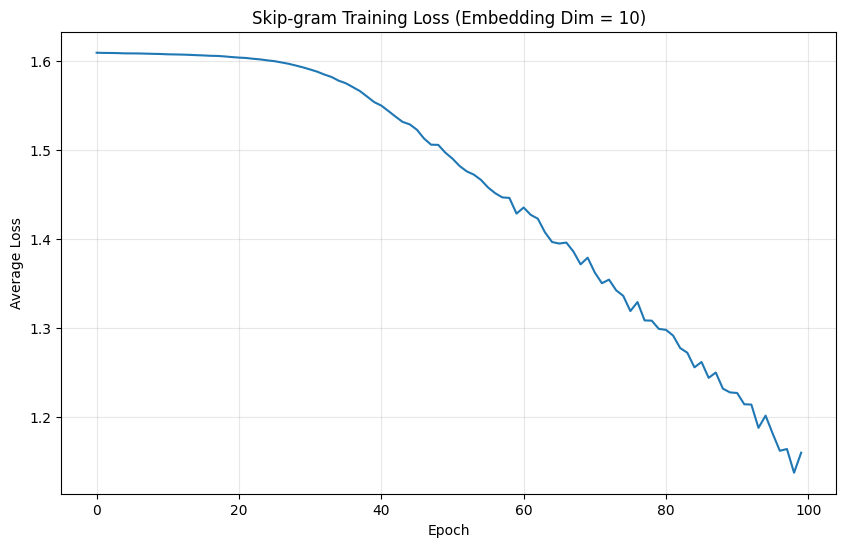


Predicting contexts for target words:
----------------------------------------

Target word: 'sea'
Predicted contexts:
  tonight: 0.018975
  tide: 0.018844
  calm: 0.018246
  lie: 0.017993
  seems: 0.017726

Target word: 'vast'
Predicted contexts:
  out: 0.021428
  glimmering: 0.020457
  armies: 0.019975
  stand: 0.019951
  tranquil: 0.019656

Target word: 'joy'
Predicted contexts:
  nor: 0.257372
  love: 0.047467
  light: 0.047400
  certitude: 0.044874
  peace: 0.039333


In [ ]:
# Part 1: Train with embedding dimension = 10
print("\nTraining with embedding dimension = 10")
print("-" * 40)

model_10d, vocab, word_to_idx, losses_10d = train_skip_gram(
    corpus, 
    embedding_dim=10, 
    epochs=100, 
    window_size=2, 
    negative_samples=4, 
    learning_rate=0.01
)

# Plot loss function
plt.figure(figsize=(10, 6))
plt.plot(losses_10d)
plt.title('Skip-gram Training Loss (Embedding Dim = 10)')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Predict contexts for target words
print("\nPredicting contexts for target words:")
print("-" * 40)
target_words = ['sea', 'vast', 'joy']
for word in target_words:
    if word in word_to_idx:
        word_idx = word_to_idx[word]
        predicted_contexts = model_10d.predict_context(word_idx, word_to_idx, top_result=5)
        
        print(f"\nTarget word: '{word}'")
        print("Predicted contexts:")
        for context_word, probability in predicted_contexts:
            print(f"  {context_word}: {probability:.6f}")
    else:
        print(f"\nWord '{word}' not found in vocabulary")


Training with embedding dimension = 2
----------------------------------------
Preprocessing corpus...
Vocabulary size after preprocessing: 63
Total words: 71
Creating training data...
Training pairs: 278
Training Skip-gram model for 100 epochs...
Epoch 0: Average Loss = 1.6100
Epoch 1: Average Loss = 1.6094
Epoch 2: Average Loss = 1.6082
Epoch 3: Average Loss = 1.6091
Epoch 4: Average Loss = 1.6066
Epoch 5: Average Loss = 1.6072
Epoch 6: Average Loss = 1.6051
Epoch 7: Average Loss = 1.6061
Epoch 8: Average Loss = 1.6037
Epoch 9: Average Loss = 1.6024
Epoch 10: Average Loss = 1.6029
Epoch 11: Average Loss = 1.6006
Epoch 12: Average Loss = 1.6006
Epoch 13: Average Loss = 1.5987
Epoch 14: Average Loss = 1.5988
Epoch 15: Average Loss = 1.5987
Epoch 16: Average Loss = 1.5950
Epoch 17: Average Loss = 1.5944
Epoch 18: Average Loss = 1.5926
Epoch 19: Average Loss = 1.5906
Epoch 20: Average Loss = 1.5862
Epoch 21: Average Loss = 1.5841
Epoch 22: Average Loss = 1.5827
Epoch 23: Average Loss = 

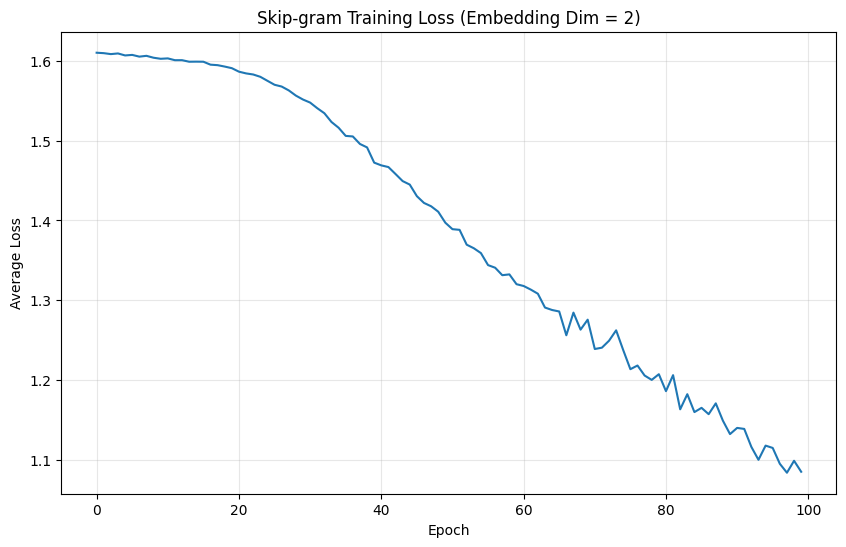


Predicting contexts for target words:
----------------------------------------

Target word: 'sea'
Predicted contexts:
  nor: 0.041179
  light: 0.026186
  love: 0.024261
  peace: 0.023232
  tonight: 0.022751

Target word: 'vast'
Predicted contexts:
  so: 0.066679
  various: 0.042207
  beautiful: 0.035705
  new: 0.035517
  land: 0.034914

Target word: 'joy'
Predicted contexts:
  nor: 0.109041
  light: 0.046090
  love: 0.037230
  peace: 0.034133
  certitude: 0.031565


In [ ]:
# Part 2: Train with embedding dimension = 2 
print("\nTraining with embedding dimension = 2")
print("-" * 40)

model_2d, vocab_2d, word_to_idx_2d, losses_2d = train_skip_gram(
    corpus, 
    embedding_dim=2, 
    epochs=100, 
    window_size=2, 
    negative_samples=4, 
    learning_rate=0.01
)

# Plot loss function
plt.figure(figsize=(10, 6))
plt.plot(losses_2d)
plt.title('Skip-gram Training Loss (Embedding Dim = 2)')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Predict contexts for target words
print("\nPredicting contexts for target words:")
print("-" * 40)
target_words = ['sea', 'vast', 'joy']
for word in target_words:
    if word in word_to_idx:
        word_idx = word_to_idx[word]
        predicted_contexts = model_2d.predict_context(word_idx, word_to_idx, top_result=5)
        
        print(f"\nTarget word: '{word}'")
        print("Predicted contexts:")
        for context_word, probability in predicted_contexts:
            print(f"  {context_word}: {probability:.6f}")
    else:
        print(f"\nWord '{word}' not found in vocabulary")


Visualizing 2D word embeddings:


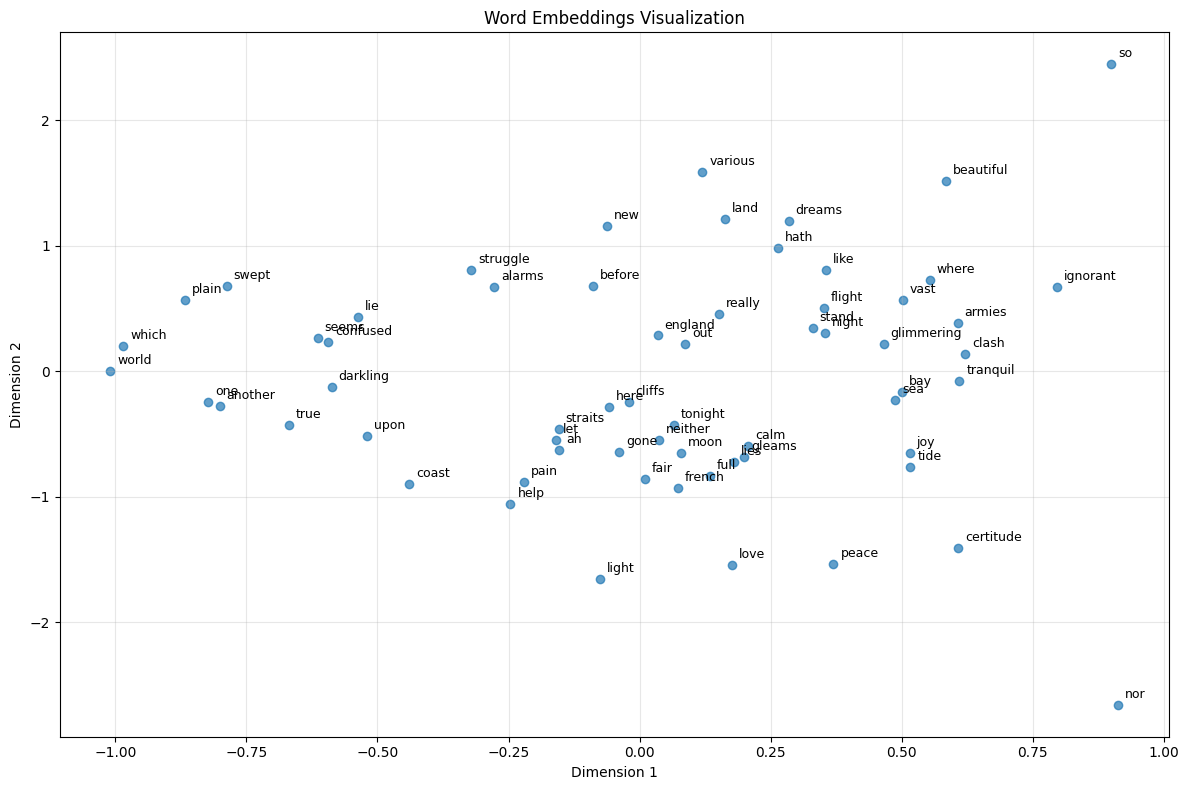

In [8]:
from sklearn.manifold import TSNE

print("\nVisualizing 2D word embeddings:")

if model_2d.embedding_dim > 2:
    # Use t-SNE to reduce dimensionality to 2D
    embeddings = model_2d.W_in
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(vocab)-1))
    embeddings_2d = tsne.fit_transform(embeddings)
else:
    # Already 2D
    embeddings_2d = model_2d.W_in

plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)

# Add word labels
for i, word in enumerate(vocab):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title("Word Embeddings Visualization")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()